In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.linear_model import Ridge
from matplotlib.colors import Normalize
import networkx as nx
from matplotlib.cm import ScalarMappable
from scipy.signal import welch

In [2]:
def lorenz_derivatives(state, t, sigma=10.0, rho=28.0, beta=8.0/3.0):
    """Compute time derivatives [dx/dt, dy/dt, dz/dt] for the Lorenz system."""
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

In [3]:
def generate_lorenz_data(
    initial_state=[1.0, 1.0, 1.0],
    tmax=25.0,
    dt=0.01,
    sigma=10.0,
    rho=28.0,
    beta=8.0/3.0
):
    """
    Numerically integrate Lorenz equations x'(t), y'(t), z'(t) using odeint.
    Returns: 
       t_vals: array of time points
       sol   : array shape [num_steps, 3] of [x(t), y(t), z(t)]
    """
    num_steps = int(tmax / dt)
    t_vals = np.linspace(0, tmax, num_steps)
    sol = odeint(lorenz_derivatives, initial_state, t_vals, args=(sigma, rho, beta))
    return t_vals, sol

In [4]:
def scale_spectral_radius(W, target_radius=0.95):
    eigvals = np.linalg.eigvals(W)
    radius = np.max(np.abs(eigvals))
    if radius == 0:
        return W
    return (W / radius) * target_radius

In [5]:
class BaselineESN3D:
    """
    A baseline Echo State Network that handles:
        - 3D input (x,y,z)
        - 3D output (x(t+1), y(t+1), z(t+1))"
    """
    def __init__(self,
                 reservoir_size=400,
                 spectral_radius=0.95,
                 input_scale=1.0,
                 leaking_rate=0.8,
                 ridge_alpha=1e-6,
                 seed=42):
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed

        np.random.seed(self.seed)
        # Initialize W with small random values (mean=0, variance=0.01)
        W = np.random.randn(reservoir_size, reservoir_size) * 0.1
        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        np.random.seed(self.seed + 100)
        # Initialize input weights in range [-input_scale, input_scale]
        self.W_in = (np.random.rand(reservoir_size, 3) - 0.5) * 2.0 * self.input_scale
        
        # Readout: shape (3, reservoir_size+1) -> 3D output
        self.W_out = None
        self.reset_state()

    def reset_state(self):
        self.x = np.zeros(self.reservoir_size)

    def _update(self, u):
        """
        Single time-step ESN update:
            x(t+1) = (1-alpha)*x(t) + alpha*tanh( W*x(t) + W_in*u(t) )
        where u is R^3 (the Lorenz state).
        """
        pre_activation = self.W @ self.x + self.W_in @ u
        x_new = np.tanh(pre_activation)
        alpha = self.leaking_rate
        self.x = (1.0 - alpha) * self.x + alpha * x_new

    def collect_states(self, inputs, discard=100):
        """
        Run reservoir on 'inputs' (shape [T, 3]), discarding the first 'discard' steps.
        Returns: states [T-discard, reservoir_size]
        """
        self.reset_state()
        states = []
        for t in range(len(inputs)):
            self._update(inputs[t])
            states.append(self.x.copy())
        states = np.array(states)
        return states[discard:], states[:discard]
    
    def fit_readout(self, train_input, train_target, discard=100):
        """
        Teacher forcing for single-step:
            - input(t) = [x(t), y(t), z(t)]
            - target(t) = [x(t+1), y(t+1), z(t+1)]
        We collect states(t), then solve a multi-output linear ridge regression:
            W_out * [x(t); 1] ~ target(t+1).
        For quadratic readout:
            W_out * [x(t); x²(t); 1] ~ target(t+1).
        """
        states_use, _ = self.collect_states(train_input, discard=discard)
        targets_use = train_target[discard:]  # shape [T-discard, 3]

        # Augment states with bias
        # X_aug = np.hstack([states_use, np.ones((states_use.shape[0], 1))])  # shape [T-discard, N+1]

        # Quadratic readout
        # Build augmented matrix [ x, x^2, 1 ]
        X_list = []
        for s in states_use:
            X_list.append( np.concatenate([s, s**2, [1.0]]) )
        X_aug = np.array(X_list)

        ridge_reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        ridge_reg.fit(X_aug, targets_use)
        self.W_out = ridge_reg.coef_

    def predict(self, inputs):
        """
        Single-step-ahead inference on test data:
        For each inputs[t], we update reservoir, then read out 3D prediction.
        """
        preds = []
        for t in range(len(inputs)):
            self._update(inputs[t])
            # x_aug = np.concatenate([self.x, [1.0]])
            x_aug = np.concatenate([self.x, (self.x)**2, [1.0]])  # For quadrartic readout
            out = self.W_out @ x_aug
            preds.append(out)
        return np.array(preds)
    
    def autoregressive_predict(self, initial_input, num_steps):
        """
        Autoregressive multi-step forecasting for num_steps
        """
        preds = []
        current_input = initial_input.copy()
      
        for _ in range(num_steps):
            self._update(current_input)
            # x_aug = np.concatenate([self.x, [1.0]])
            x_aug = np.concatenate([self.x, (self.x)**2, [1.0]])  # For quadratic readout
            out = self.W_out @ x_aug
            preds.append(out)
            current_input = out
        
        return np.array(preds)

In [6]:
class CycleReservoir3D(BaselineESN3D):
    """
    Cyclic Reservoir for 3D -> 3D Lorenz.
    - reservoir_size, spectral_radius, input_scale, leaking_rate, ridge_alpha as in baseline
    """
    def __init__(self,
                 reservoir_size=400,
                 spectral_radius=0.95,
                 input_scale=1.0,
                 leaking_rate=0.8,
                 ridge_alpha=1e-6,
                 seed=42):
        
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed

        np.random.seed(self.seed)
        # Build cycle adjacency: W[i,(i+1)%N] = 1
        W = np.zeros((reservoir_size, reservoir_size))
        for i in range(reservoir_size):
            j = (i+1) % reservoir_size
            W[i, j] = 1.0

        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        np.random.seed(self.seed + 100)
        # Initialize input weights in range [-input_scale, input_scale]
        self.W_in = (np.random.rand(self.reservoir_size, 3) - 0.5) * 2.0 * self.input_scale

        # Readout: shape (3, reservoir_size+1) -> 3D output
        self.W_out = None
        self.reset_state()


In [7]:
class SparseESN3D(BaselineESN3D):
    """
    Sparse ESN for 3D->3D Lorenz.
    - connectivity: fraction of non_zero entries in W
    - reservoir_size, spectral_radius, input_scale, leaking_rate, ridge_alpha as in baseline
    """
    def __init__(self,
                 reservoir_size=400,
                 spectral_radius=0.95,
                 connectivity=0.05,  # fraction of non-zero entries in W
                 input_scale=1.0,
                 leaking_rate=0.8,
                 ridge_alpha=1e-6,
                 seed=42):
        
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.connectivity = connectivity
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed

        np.random.seed(self.seed)
        # Initialize W with small random values (mean=0, variance=0.01)
        W = np.random.randn(reservoir_size, reservoir_size) * 0.1
        # Create a boolean sparsity mask
        mask = (np.random.rand(reservoir_size, reservoir_size) < self.connectivity)
        W = W * mask
        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        np.random.seed(self.seed + 100)
        # Initialize input weights in range [-input_scale, input_scale]
        self.W_in = (np.random.rand(self.reservoir_size, 3) - 0.5) * 2.0 * self.input_scale

        # Readout: shape (3, reservoir_size+1) -> 3D output
        self.W_out = None
        self.reset_state()


In [8]:
def hyperbolic_distance_poincare(u, v):
    """
    Compute the hyperbolic distance d(u, v) in the Poincaré disk model (2D).
    Both u, v in R^2 with ||u|| < 1, ||v|| < 1.
    Formula: 
      d(u,v) = arcosh(1 + 2 * ||u - v||^2 / ((1 - ||u||^2)*(1 - ||v||^2)))
    If either point is near radius=1, numerical instability might occur. 
    """

    norm_u_squared = np.dot(u, u)
    norm_v_squared = np.dot(v, v)
    
    # clamp to avoid negative denominators if norms ~1
    eps = 1e-14
    one_minus_u = max(eps, 1.0 - norm_u_squared)
    one_minus_v = max(eps, 1.0 - norm_v_squared)
    
    diff = u - v
    diff_squared = np.dot(diff, diff)  # Euclidean squared
    
    arg = 1.0 + 2.0 * diff_squared / (one_minus_u * one_minus_v)
    if arg < 1.0:
        arg = 1.0
    return np.arccosh(arg)

In [9]:
def draw_hyperbolic_reservoir(positions, W, save_path="Figures/hyperbolic_reservoir.png"):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ax.set_frame_on(False)
    ax.add_patch(plt.Circle((0, 0), 1, color='black', fill=False, linestyle='dashed'))

    radial_distances = np.linalg.norm(positions, axis=1)
    norm = Normalize(vmin=0, vmax=np.max(radial_distances))
    cmap = plt.cm.viridis

    G = nx.Graph()
    N = len(positions)
    for i in range(N):
        G.add_node(i, pos=positions[i])
    
    for i in range(N):
        ax.scatter(positions[i, 0], positions[i, 1], color=cmap(norm(radial_distances[i])), s=50, edgecolors='k', linewidth=0.5)
    
    for i in range(N):
        for j in range(N):
            if W[i, j] > 0:
                x_vals = [positions[i, 0], positions[j, 0]]
                y_vals = [positions[i, 1], positions[j, 1]]
                ax.plot(x_vals, y_vals, color=(0, 0, 1, W[i, j]), linewidth=W[i, j]*8)

    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Radial Distance")
    
    plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()


In [10]:
class HyperbolicRes3D(BaselineESN3D):
    """
    Hyperbolic Embedding Reservoir (HER) for 3D->3D Lorenz,
    using the Poincaré disc model:
      1) Sample each node from the unit Poincaré disc. 
      2) Compute Hyperbolic Distance dist(u_i, u_j).
      3) Adjacency W_ij = exp( - dist(u_i, u_j)/ sigma ), or 0 to enforce row-sparsity beyond top_k or fraction.
      4) Scale spectral radius to optimum value.
      5) Leaky ESN update with [x, x^2, 1] readout.
    """

    def __init__(self,
                 reservoir_size=300,
                 disk_radius=0.99,              # max radius inside the Poincaré disk (slightly < 1 to avoid boundary
                 sigma=0.5,                     # kernel width for adjacency
                 top_k=0,                       # if >0, keep only top_k largest entries in each row
                 activation_choices=('tanh','relu','sin','linear'),
                 spectral_radius=0.95,
                 input_scale=1.0, 
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42):
        """
        reservoir_size      : number of nodes
        disk_radius         : we sample node positions r<disk_radius < 1 for Poincaré disk
        sigma               : kernel width used in adjacency
        top_k               : if >0, keep only top_k in each row, else 0
        activation_choices  : set of activation types to randomly assign
        spectral_radius     : final adjacency scale
        input_scale         : scale for W_in
        leaking_rate        : ESN leak factor
        ridge_alpha         : readout ridge penalty
        seed                : random seed
        """

        self.reservoir_size = reservoir_size
        self.disk_radius = disk_radius
        self.sigma = sigma
        self.top_k = top_k
        self.activation_choices = activation_choices
        self.spectral_radius = spectral_radius
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed
        
        np.random.seed(self.seed)
        # Pick angle ~ Uniform (0,2*pi)
        angles = 2.0 * np.pi * np.random.rand(self.reservoir_size)
        # Convert the Euclidean boundary radius to hyperbolic radius
        hyperbolic_radius = 2 * np.arctanh(self.disk_radius)
        r_unif = np.arccosh(np.random.rand(self.reservoir_size) * (np.cosh(hyperbolic_radius) - 1) + 1)
        positions = np.zeros((self.reservoir_size, 2))
        for i in range(self.reservoir_size):
            positions[i,0] = np.tanh(r_unif[i]/2) * np.cos(angles[i])
            positions[i,1] = np.tanh(r_unif[i]/2) * np.sin(angles[i])
        self.positions = positions


        # Build adjacency with hyperbolic_distance_poincare + kernel
        W = np.zeros((self.reservoir_size, self.reservoir_size))
        for i in range(self.reservoir_size):
            for j in range(self.reservoir_size):
                if i == j:
                    continue
                d_ij = hyperbolic_distance_poincare(self.positions[i], self.positions[j])
                val = np.exp(- d_ij / self.sigma)
                W[i, j] = val

        # Row-level sparsity
        if self.top_k > 0:
            for i in range(self.reservoir_size):
                row = W[i,:]
                idx_sorted = np.argsort(row)[::-1]
                keep_count = min(self.top_k, self.reservoir_size)
                row_mask = np.zeros(self.reservoir_size, dtype=bool)
                row_mask[idx_sorted[:keep_count]] = True
                W[i, ~row_mask] = 0.0

        # Scale spectral radius
        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        draw_hyperbolic_reservoir(self.positions, W)

        np.random.seed(self.seed + 100)
        # Initialize input weights in range [-input_scale, input_scale]
        self.W_in = (np.random.rand(self.reservoir_size, 3) - 0.5) * 2.0 * self.input_scale

        np.random.seed(self.seed + 200)
        self.node_activations = np.random.choice(self.activation_choices, size=self.reservoir_size)

        # Readout: shape (3, reservoir_size+1) -> 3D output
        self.W_out = None
        self.reset_state()

    def _apply_activation(self, act_type, val):
        if act_type=='tanh':
            return np.tanh(val)
        elif act_type=='relu':
            return max(0.0, val)
        elif act_type=='sin':
            return np.sin(val)
        elif act_type=='linear':
            return val
        else:
            return np.tanh(val)

    def _update(self, u):
        """
        x(t+1) = (1-alpha)*x(t) + alpha*[ node-by-node activation( W*x(t)+W_in*u ) ]
        """
        pre_activations = self.W @ self.x + self.W_in @ u
        x_new = np.zeros_like(self.x)
        for i in range(self.reservoir_size):
            activation = self.node_activations[i]
            x_new[i] = self._apply_activation(activation, pre_activations[i])
        alpha = self.leaking_rate
        self.x = (1.0 - alpha)*self.x + alpha*x_new


In [11]:
tmax = 150.0
dt = 0.02
t_vals, lorenz_trajectory = generate_lorenz_data(
    initial_state=[1.0, 1.0, 1.0], 
    tmax=tmax,
    dt=dt,
    sigma=10.0,
    rho=28.0,
    beta=8.0/3.0
)

# Discard first 2,000 points as washout
washout = 2000
t_vals = t_vals[washout:]
lorenz_trajectory = lorenz_trajectory[washout:]

In [12]:
# # Normalize data
# data_min = lorenz_trajectory.min(axis=0)
# data_max = lorenz_trajectory.max(axis=0)
# lorenz_trajectory = (lorenz_trajectory - data_min) / (data_max - data_min)

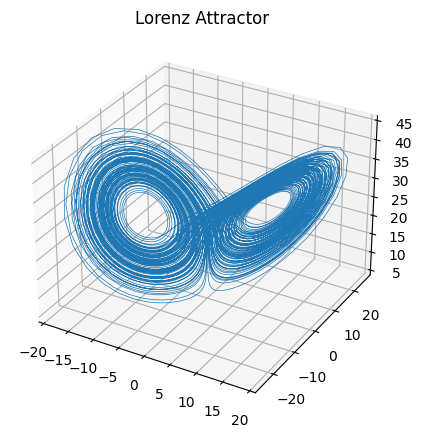

In [13]:
# Visualizing Lorenz attractor
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')
ax.plot(lorenz_trajectory[:, 0], lorenz_trajectory[:, 1], lorenz_trajectory[:, 2], lw=0.5)
ax.set_title("Lorenz Attractor")
plt.show()

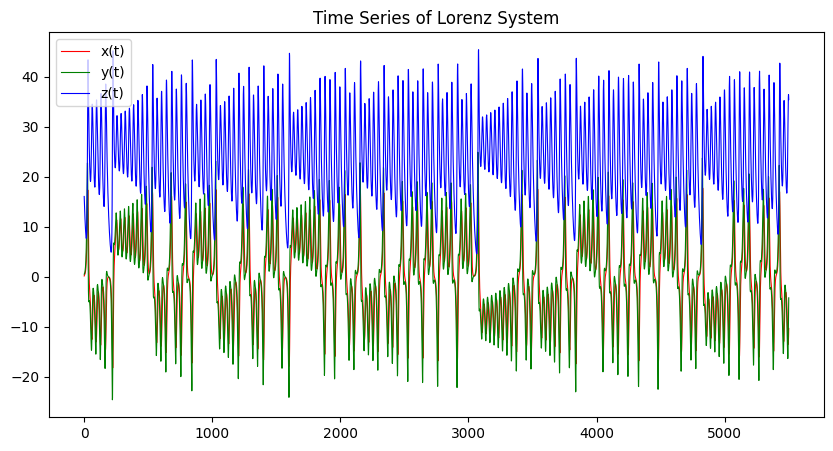

In [14]:
t = np.linspace(0, len(lorenz_trajectory), len(lorenz_trajectory))

plt.figure(figsize=(10, 5))
plt.plot(t, lorenz_trajectory[:, 0], label='x(t)', color='r', lw=0.8)
plt.plot(t, lorenz_trajectory[:, 1], label='y(t)', color='g', lw=0.8)
plt.plot(t, lorenz_trajectory[:, 2], label='z(t)', color='b', lw=0.8)

plt.title("Time Series of Lorenz System")
plt.legend()
plt.show()

In [15]:
# Prepare single-step data: input(t) = [x(t), y(t), z(t)], target(t)=[x(t+1), y(t+1), z(t+1)]
inputs = lorenz_trajectory[:-1]
targets = lorenz_trajectory[1:]

In [16]:
data_size = len(lorenz_trajectory)-1
train_size = 4500
train_input = inputs[:train_size]
train_target = targets[:train_size]
test_input = inputs[train_size:]
test_target = targets[train_size:]
test_size = len(test_input)
print(f"Total samples: {data_size}, train size: {train_size}, test size: {test_size}") 

Total samples: 5499, train size: 4500, test size: 999


## Teacher-forced Single-step Forecasting

In [17]:
# Define horizons to test
all_horizons = list(range(10, 1001, 10))
horizons = [200, 400, 600, 800, 1000]

In [18]:
def evaluate_nrmse(all_preds, test_target, horizons):
    """
    Evaluate model performance over multiple prediction horizons for Teacher-forced Single-step Forecasting
    """
    horizon_nrmse = {}
    
    for horizon in horizons:
        preds = all_preds[:horizon]
        targets = test_target[:horizon]
        squared_errors = (preds - targets)**2
        variance = np.var(targets, axis=0)
        nrmse = np.sqrt(np.sum(squared_errors) / (horizon * variance))
        horizon_nrmse[horizon] = nrmse

    return horizon_nrmse

In [19]:
# Baseline ESN
esn = BaselineESN3D(
    reservoir_size=300,
    spectral_radius=1.0,
    input_scale=0.2,
    leaking_rate=0.8,
    ridge_alpha=1e-6,
    seed=1002
)
esn.fit_readout(train_input, train_target, discard=100)
esn_preds = esn.predict(test_input)

In [20]:
# Cycle Reservoir
cycle_res = CycleReservoir3D(
    reservoir_size=300,
    spectral_radius=1.0,
    input_scale=0.2,
    leaking_rate=0.8,
    ridge_alpha=1e-6,
    seed=1002
)
cycle_res.fit_readout(train_input, train_target, discard=100)
cycle_res_preds = cycle_res.predict(test_input)

In [21]:
# Sparse ESN
sparse_esn = SparseESN3D(
    reservoir_size=300,
    spectral_radius=1.0,
    connectivity=0.05,
    input_scale=0.2,
    leaking_rate=0.8,
    ridge_alpha=1e-6,
    seed=1002
)
sparse_esn.fit_readout(train_input, train_target, discard=100)
sparse_esn_preds = sparse_esn.predict(test_input)

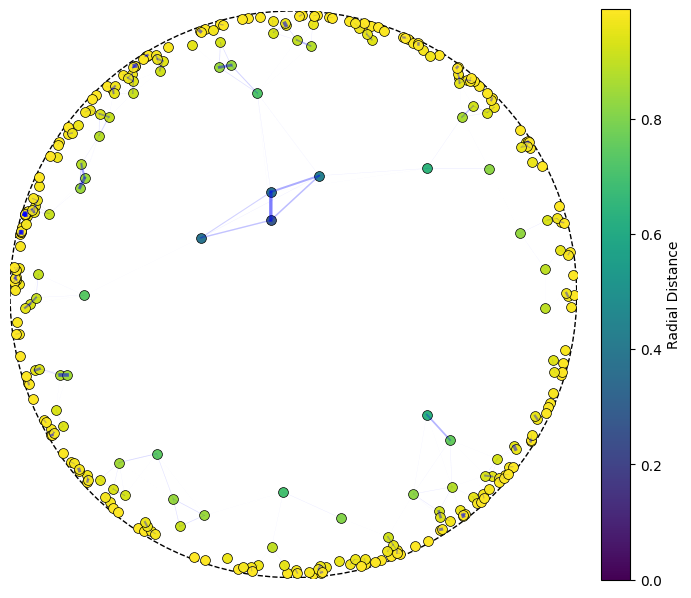

In [22]:
hyperbolic_res = HyperbolicRes3D(
        reservoir_size=300,
        disk_radius=0.99, 
        sigma=0.4,
        top_k=20,
        spectral_radius=1.0,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=1002
    )
hyperbolic_res.fit_readout(train_input, train_target, discard=100)
hyperbolic_res_preds = hyperbolic_res.predict(test_input)

In [23]:
esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
sparse_esn_nrmse = evaluate_nrmse(sparse_esn_preds, test_target, all_horizons)
hyperbolic_res_nrmse = evaluate_nrmse(hyperbolic_res_preds, test_target, all_horizons)

In [24]:
# Print results
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 70)
print(f"{'Horizon':<10} {'ESN':<15} {'CycleRes':<15} {'SparseESN':<15} {'HyperbolicRes':<15}")
print("-" * 70)

for horizon in horizons:
    print(f"{horizon:<10} {np.mean(esn_nrmse[horizon]):<15.7f} {np.mean(cycle_res_nrmse[horizon]):<15.7f} {np.mean(sparse_esn_nrmse[horizon]):<15.7f} {np.mean(hyperbolic_res_nrmse[horizon]):<15.7f}")


NRMSE for Different Prediction Horizons:
----------------------------------------------------------------------
Horizon    ESN             CycleRes        SparseESN       HyperbolicRes  
----------------------------------------------------------------------
200        0.0000664       0.0000284       0.0000707       0.0000016      
400        0.0001173       0.0000778       0.0001485       0.0000031      
600        0.0001034       0.0000666       0.0001280       0.0000027      
800        0.0000954       0.0000593       0.0001143       0.0000025      
1000       0.0000907       0.0000547       0.0001080       0.0000023      


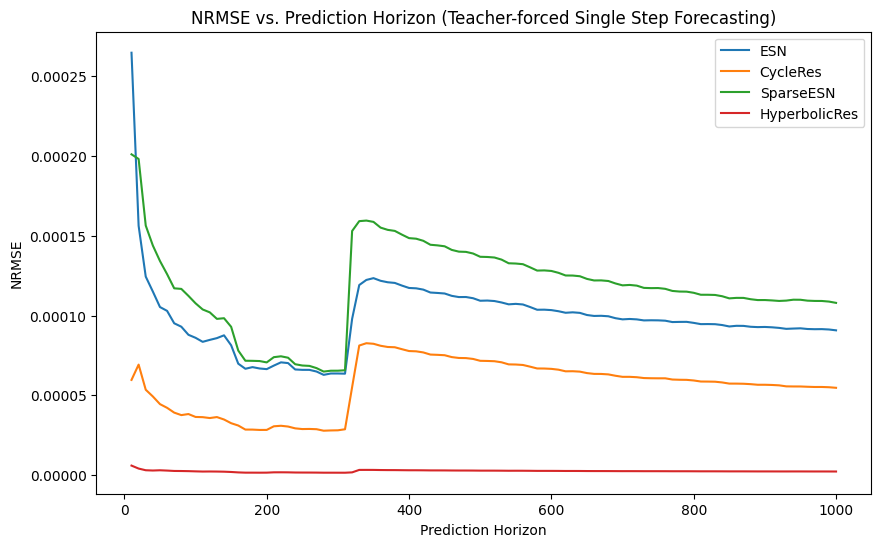

In [25]:
# Plot NRMSE vs Horizon
plot_len=1000
steps = list(range(10, plot_len+1, 10))

plt.figure(figsize=(10, 6))
plt.plot(steps, [np.mean(esn_nrmse[s]) for s in steps], label='ESN')
plt.plot(steps, [np.mean(cycle_res_nrmse[s]) for s in steps], label='CycleRes')
plt.plot(steps, [np.mean(sparse_esn_nrmse[s]) for s in steps], label='SparseESN')
plt.plot(steps, [np.mean(hyperbolic_res_nrmse[s]) for s in steps], label='HyperbolicRes')
plt.xlabel('Prediction Horizon')
plt.ylabel('NRMSE')
plt.title('NRMSE vs. Prediction Horizon (Teacher-forced Single Step Forecasting)')
plt.legend()
plt.savefig("Figures/NRMSE vs. Prediction Horizon (Teacher-forced Single Step Forecasting).png", dpi=600, bbox_inches='tight')
plt.show()

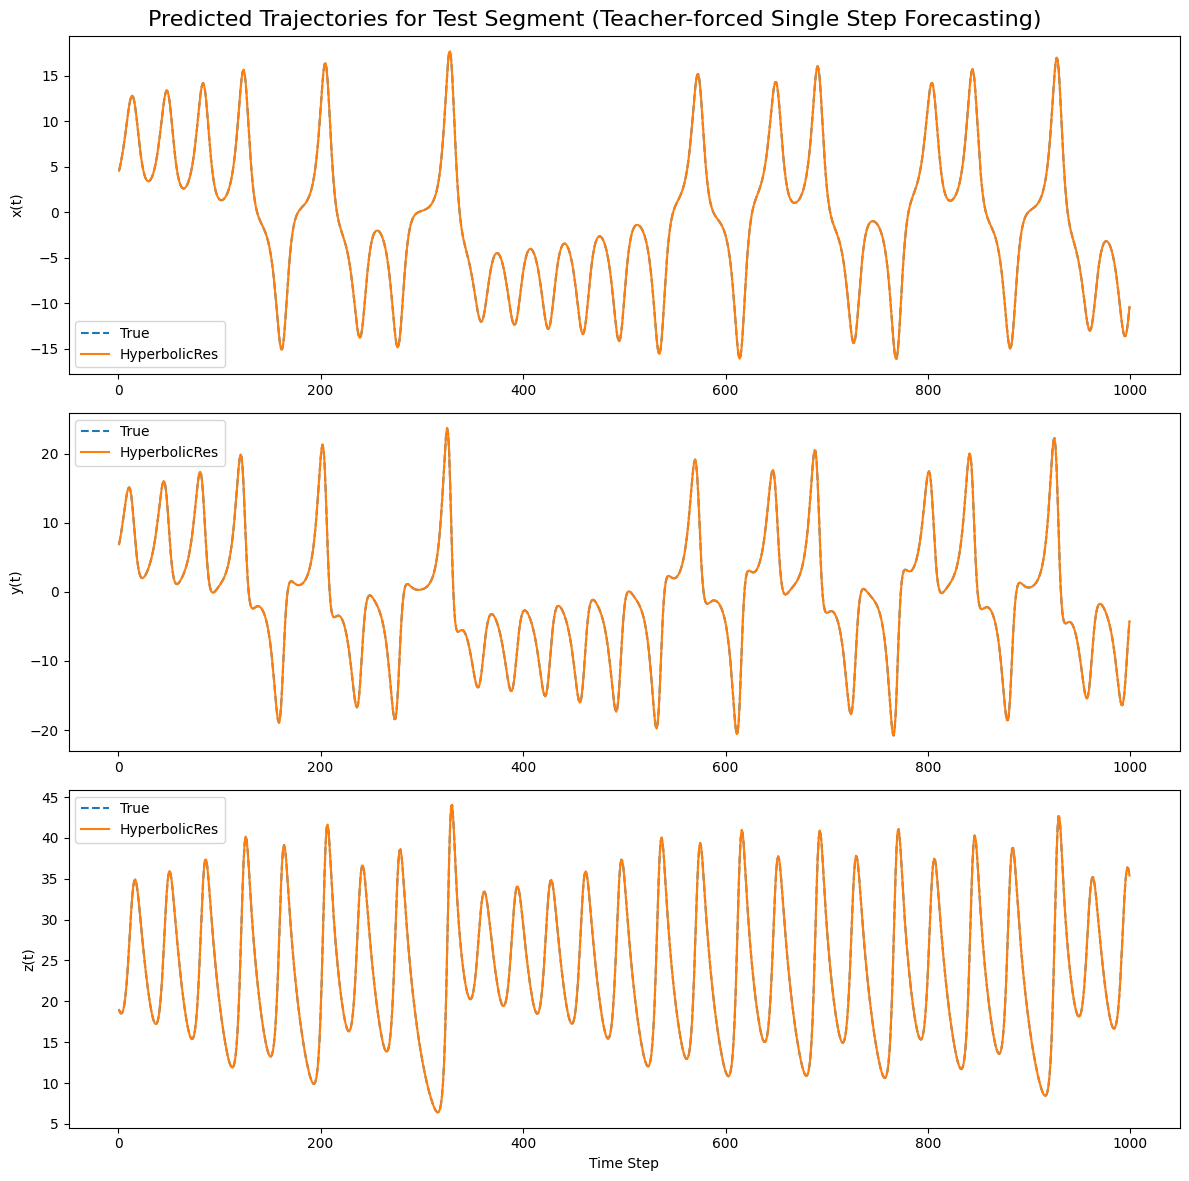

In [26]:
plot_len = 999
steps = list(range(1, plot_len+1))

# Create subplots for x, y, z dimensions
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

dims = ['x(t)', 'y(t)', 'z(t)']
for i in range(3):
    axes[i].plot(steps, test_target[:plot_len, i], label='True', linestyle='dashed')
    # axes[i].plot(steps, esn_preds[:plot_len, i], label='ESN')
    # axes[i].plot(steps, cycle_res_preds[:plot_len, i], label='CycleRes')
    # axes[i].plot(steps, sparse_esn_preds[:plot_len, i], label='SparseESN')
    axes[i].plot(steps, hyperbolic_res_preds[:plot_len, i], label='HyperbolicRes')
    axes[i].set_ylabel(dims[i])
    axes[i].legend()

axes[-1].set_xlabel('Time Step')
fig.suptitle('Predicted Trajectories for Test Segment (Teacher-forced Single Step Forecasting)', fontsize=16)
plt.tight_layout()
plt.savefig("Figures/Predicted Trajectories for Test Segment (Teacher-forced Single Step Forecasting).png", dpi=600, bbox_inches='tight')
plt.show()

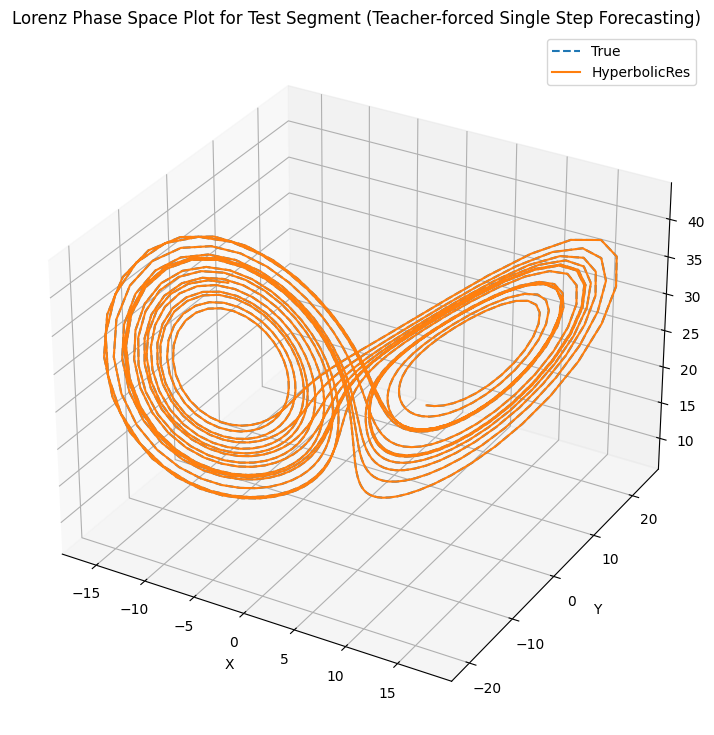

In [27]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.plot(test_target[:plot_len,0], test_target[:plot_len,1], test_target[:plot_len,2], label='True', linestyle='dashed')
ax.plot(hyperbolic_res_preds[:plot_len,0], hyperbolic_res_preds[:plot_len,1], hyperbolic_res_preds[:plot_len,2], label='HyperbolicRes')
ax.set_title('Lorenz Phase Space Plot for Test Segment (Teacher-forced Single Step Forecasting)')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.legend()
plt.savefig("Figures/Lorenz Phase Space Plot for Test Segment (Teacher-forced Single Step Forecasting).png", dpi=600, bbox_inches='tight')
plt.show()

## Autoregressive Forecasting

In [28]:
initial_input = test_input[0]
num_steps = len(test_input)

In [29]:
# Baseline ESN
esn = BaselineESN3D(
    reservoir_size=300,
    spectral_radius=1.0,
    input_scale=0.2,
    leaking_rate=0.8,
    ridge_alpha=1e-6,
    seed=1002
)
esn.fit_readout(train_input, train_target, discard=100)
esn_preds = esn.autoregressive_predict(initial_input, num_steps)

In [30]:
# Cycle Reservoir
cycle_res = CycleReservoir3D(
    reservoir_size=300,
    spectral_radius=1.0,
    input_scale=0.2,
    leaking_rate=0.8,
    ridge_alpha=1e-6,
    seed=1002
)
cycle_res.fit_readout(train_input, train_target, discard=100)
cycle_res_preds = cycle_res.autoregressive_predict(initial_input, num_steps)

In [31]:
# Sparse ESN
sparse_esn = SparseESN3D(
    reservoir_size=300,
    spectral_radius=1.0,
    connectivity=0.05,
    input_scale=0.2,
    leaking_rate=0.8,
    ridge_alpha=1e-6,
    seed=1002
)
sparse_esn.fit_readout(train_input, train_target, discard=100)
sparse_esn_preds = sparse_esn.autoregressive_predict(initial_input, num_steps)

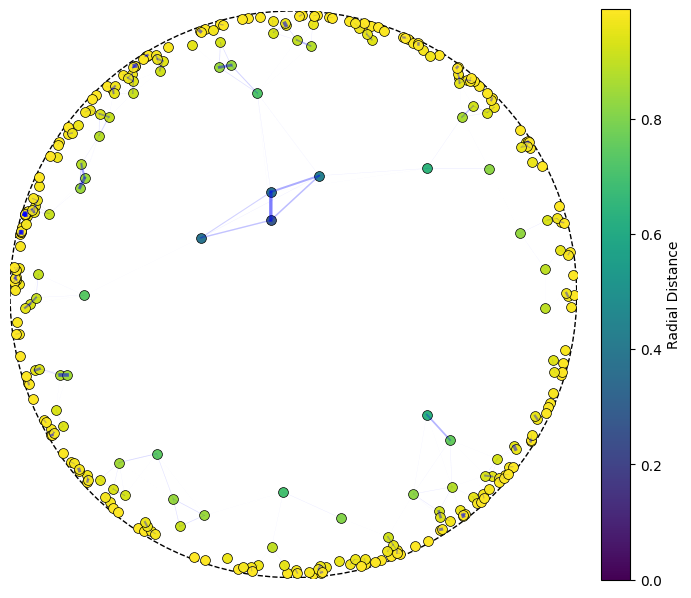

In [32]:
hyperbolic_res = HyperbolicRes3D(
        reservoir_size=300,
        disk_radius=0.99, 
        sigma=0.4,
        top_k=20,
        spectral_radius=1.0,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=1002
    )
hyperbolic_res.fit_readout(train_input, train_target, discard=100)
hyperbolic_res_preds = hyperbolic_res.autoregressive_predict(initial_input, num_steps)

In [33]:
esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
sparse_esn_nrmse = evaluate_nrmse(sparse_esn_preds, test_target, all_horizons)
hyperbolic_res_nrmse = evaluate_nrmse(hyperbolic_res_preds, test_target, all_horizons)

# Print results
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 72)
print(f"{'Horizon':<10} {'ESN':<15} {'CycleRes':<15} {'SparseESN':<15} {'HyperbolicRes':<15}")
print("-" * 72)

for horizon in horizons:
    print(f"{horizon:<10} {np.mean(esn_nrmse[horizon]):<15.6f} {np.mean(cycle_res_nrmse[horizon]):<15.6f} {np.mean(sparse_esn_nrmse[horizon]):<15.6f} {np.mean(hyperbolic_res_nrmse[horizon]):<15.6f}")


NRMSE for Different Prediction Horizons:
------------------------------------------------------------------------
Horizon    ESN             CycleRes        SparseESN       HyperbolicRes  
------------------------------------------------------------------------
200        1.037804        1.442762        0.297423        0.000065       
400        8.655391        2.065000        2.543748        0.000232       
600        10.199557       2.360184        3.311816        0.001283       
800        10.674209       2.331583        3.698100        0.113884       
1000       10.949984       2.388223        3.879874        0.886606       


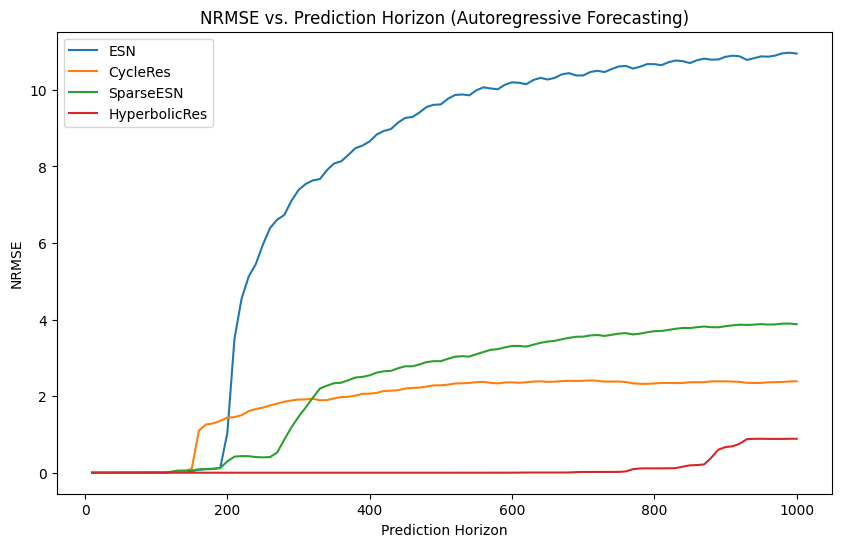

In [34]:
# Plot NRMSE vs Horizon
plot_len=1000
steps = list(range(10, plot_len+1, 10))

plt.figure(figsize=(10, 6))
plt.plot(steps, [np.mean(esn_nrmse[s]) for s in steps], label='ESN')
plt.plot(steps, [np.mean(cycle_res_nrmse[s]) for s in steps], label='CycleRes')
plt.plot(steps, [np.mean(sparse_esn_nrmse[s]) for s in steps], label='SparseESN')
plt.plot(steps, [np.mean(hyperbolic_res_nrmse[s]) for s in steps], label='HyperbolicRes')
plt.xlabel('Prediction Horizon')
plt.ylabel('NRMSE')
plt.title('NRMSE vs. Prediction Horizon (Autoregressive Forecasting)')
plt.legend()
plt.savefig("Figures/NRMSE vs. Prediction Horizon (Autoregressive Forecasting).png", dpi=600, bbox_inches='tight')
plt.show()

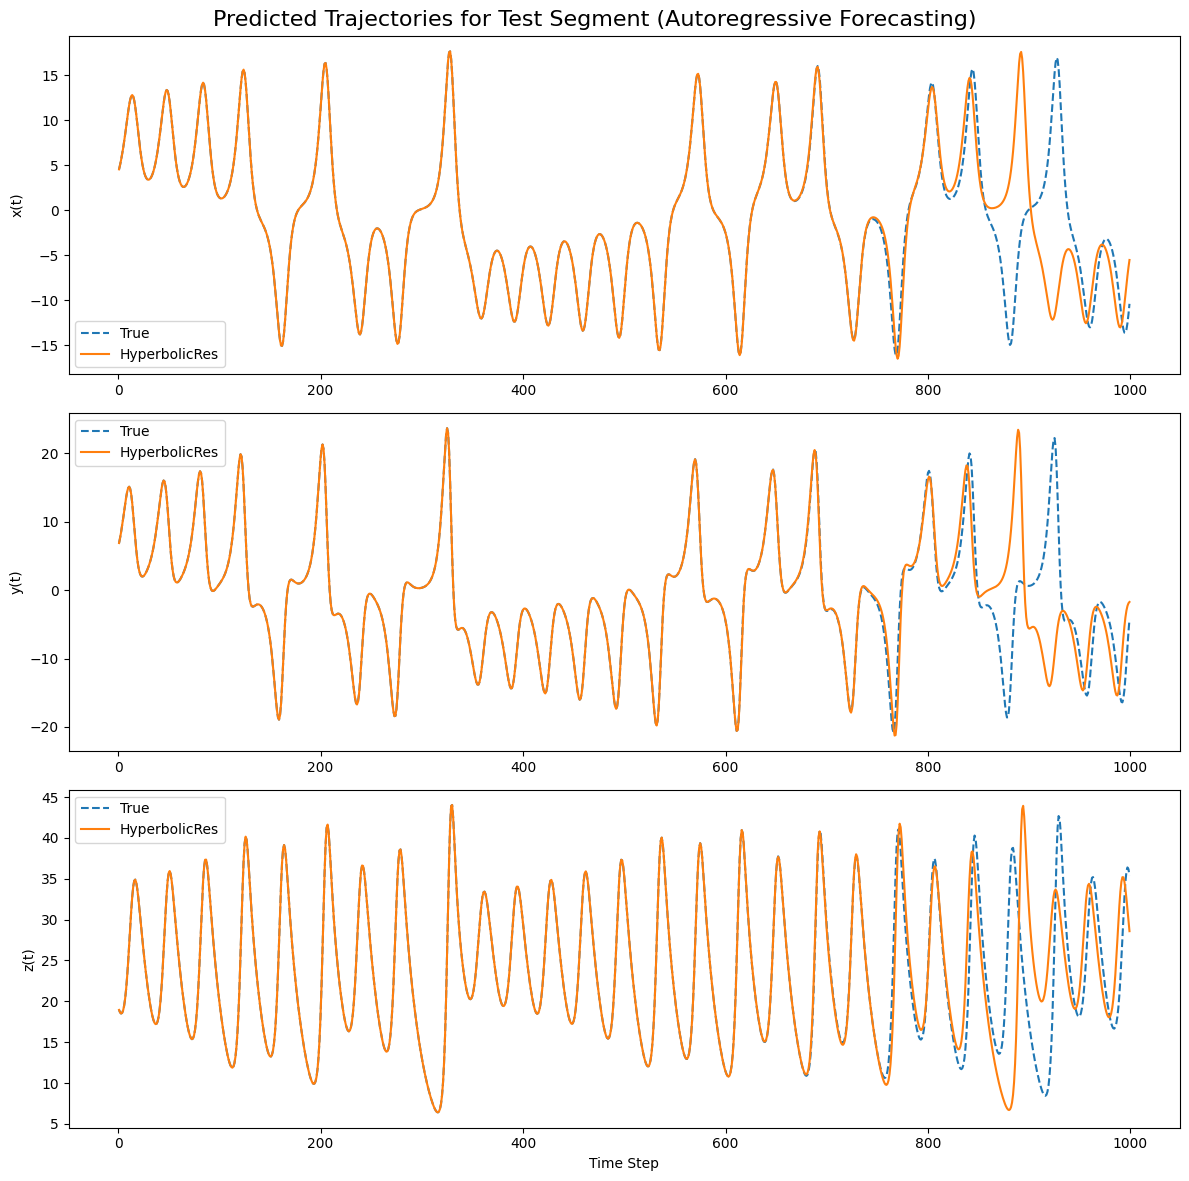

In [35]:
plot_len=999
steps = list(range(1, plot_len+1))

# Create subplots for x, y, z dimensions
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

dims = ['x(t)', 'y(t)', 'z(t)']
for i in range(3):
    axes[i].plot(steps, test_target[:plot_len, i], label='True', linestyle='dashed')
    axes[i].plot(steps, hyperbolic_res_preds[:plot_len, i], label='HyperbolicRes')
    axes[i].set_ylabel(dims[i])
    axes[i].legend()

# Set common X-axis label
axes[-1].set_xlabel('Time Step')
fig.suptitle('Predicted Trajectories for Test Segment (Autoregressive Forecasting)', fontsize=16)
plt.tight_layout()
plt.savefig("Figures/Predicted Trajectories for Test Segment (Autoregressive Forecasting).png", dpi=600, bbox_inches='tight')
plt.show()

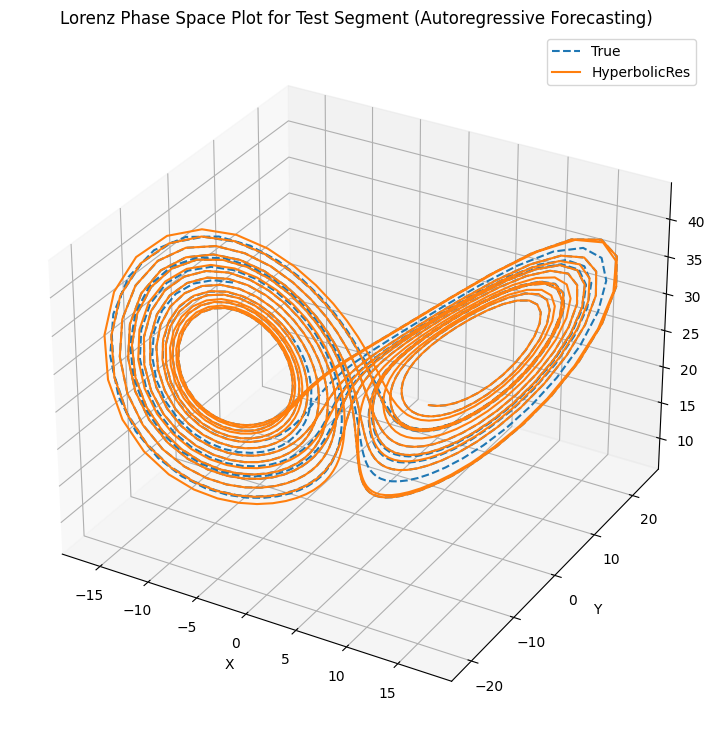

In [36]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.plot(test_target[:plot_len,0], test_target[:plot_len,1], test_target[:plot_len,2], label='True', linestyle='dashed')
# ax.plot(esn_preds[:plot_len,0], esn_preds[:plot_len,1], esn_preds[:plot_len,2], label='ESN')
ax.plot(hyperbolic_res_preds[:plot_len,0], hyperbolic_res_preds[:plot_len,1], hyperbolic_res_preds[:plot_len,2], label='HyperbolicRes')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_title('Lorenz Phase Space Plot for Test Segment (Autoregressive Forecasting)')
ax.legend()
plt.savefig("Figures/Lorenz Phase Space Plot for Test Segment (Autoregressive Forecasting).png", dpi=600, bbox_inches='tight')
plt.show()

In [37]:
def compute_valid_prediction_time(y_true, y_pred, test_time, lyapunov_time, threshold=0.4):
    y_mean = np.mean(y_true, axis=0)
    y_centered = y_true - y_mean
    denom = np.mean(np.sum(y_centered**2, axis=1))

    error = y_true - y_pred
    squared_error = np.sum(error**2, axis=1)
    delta = squared_error / denom

    idx_exceed = np.where(delta > threshold)[0]
    if len(idx_exceed) == 0:
        # never exceeds threshold => set T_VPT to the final time
        T_VPT = test_time[-1]
    else:
        T_VPT = test_time[idx_exceed[0]]

    ratio = T_VPT / lyapunov_time

    return T_VPT, ratio

In [38]:
lle_lorenz = 0.905
lyapunov_time_lorenz = 1.0 / lle_lorenz
VPT_threshold = 0.4
test_time = np.arange(test_size)*dt

esn_VPT, esn_VPT_ratio = compute_valid_prediction_time(test_target, esn_preds, test_time, lyapunov_time_lorenz, VPT_threshold)
cycle_res_VPT, cycle_res_VPT_ratio = compute_valid_prediction_time(test_target, cycle_res_preds, test_time, lyapunov_time_lorenz, VPT_threshold)
sparse_esn_VPT, sparse_esn_VPT_ratio = compute_valid_prediction_time(test_target, sparse_esn_preds, test_time, lyapunov_time_lorenz, VPT_threshold)
hyperbolic_res_VPT, hyperbolic_res_VPT_ratio = compute_valid_prediction_time(test_target, hyperbolic_res_preds, test_time, lyapunov_time_lorenz, VPT_threshold)


In [39]:
print(f"{'':<20} {'ESN':<15} {'CycleRes':<15} {'SparseESN':<15} {'HyperbolicRes':<15}")
print("-" * 82)
print(f"{'T_VPT':<20} {esn_VPT:<15.3f} {cycle_res_VPT:<15.3f} {sparse_esn_VPT:<15.3f} {hyperbolic_res_VPT:<15.3f}")
print(f"{'T_VPT/T_lambda':<20} {esn_VPT_ratio:<15.3f} {cycle_res_VPT_ratio:<15.3f} {sparse_esn_VPT_ratio:<15.3f} {hyperbolic_res_VPT_ratio:<15.3f}")

                     ESN             CycleRes        SparseESN       HyperbolicRes  
----------------------------------------------------------------------------------
T_VPT                3.860           3.020           3.920           16.740         
T_VPT/T_lambda       3.493           2.733           3.548           15.150         


In [40]:
def compute_psd(y, dt=0.01):
    z = y[:, 2]  # Extract Z-component
    
    # Compute PSD using Welch’s method
    freqs, psd = welch(z, fs=1/dt, window='hamming', nperseg=len(z))  # Using Hamming window
    
    return freqs, psd


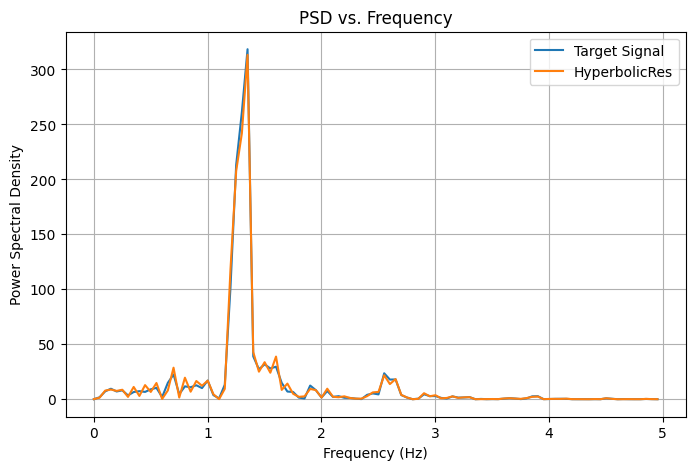

In [41]:
target_freqs, target_psd = compute_psd(test_target, dt=dt)
esn_freqs, esn_psd = compute_psd(esn_preds, dt=dt)
cycle_res_freqs, cycle_res_psd = compute_psd(cycle_res_preds, dt=dt)
sparse_esn_freqs, sparse_esn_psd = compute_psd(sparse_esn_preds, dt=dt)
hyperbolic_res_freqs, hyperbolic_res_psd = compute_psd(hyperbolic_res_preds, dt=dt)


# Plot the PSDs
mask = target_freqs <= 5
plt.figure(figsize=(8, 5))
plt.plot(target_freqs[mask], target_psd[mask], label='Target Signal')
# plt.plot(esn_freqs[mask], esn_psd[mask], label='ESN')
# plt.plot(cycle_res_freqs[mask], cycle_res_psd[mask], label='CycleRes')
# plt.plot(sparse_esn_freqs[mask], sparse_esn_psd[mask], label='SparseESN')
plt.plot(hyperbolic_res_freqs[mask], hyperbolic_res_psd[mask], label='HyperbolicRes')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('PSD vs. Frequency')
plt.legend()
plt.grid()
plt.savefig("Figures/PSD vs Frequency.png", dpi=600, bbox_inches='tight')
plt.show()
